<div style="text-align: center;">
  <img src="https://github.com/Hack-io-Data/Imagenes/blob/main/01-LogosHackio/logo_naranja@4x.png?raw=true" alt="esquema" />
</div>


# Laboratorio NLP + Sist. Recomendación


En este laboratorio, tabrajaras con datos de reseñas de productos para construir un sistema de recomendación que utilice procesamiento de lenguaje natural (NLP) y *machine learning*. El objetivo principal es que analices el contenido textual de las reseñas, clasifiques las opiniones en categorías (positiva, negativa o neutra) y aproveches esta información para personalizar las recomendaciones. El sistema priorizará los productos con mejores reseñas para usuarios específicos y permitirá evaluar si el análisis de sentimientos mejora la calidad de las recomendaciones. Tareas propuestas:


**Caso 1: Crear un sistema de recomendación**: Debes generar un sistema de recomendación para priorizar productos con las reseñas para cada usuario. Los pasos que deberás seguir son:    

- Estructurar el conjunto de datos

- Sistema basado en contenido


**Caso 2: Clasificar reseñas en positivas, negativas o neutras** Deberás implementar un modelo para analizar las reseñas textuales y clasificarlas en tres categorías:

- Positivas: Si el sentimiento de la reseña es favorable.

- Negativas: Si el sentimiento de la reseña es desfavorable.

- Neutras: Si la reseña no tiene un sentimiento claro.
	
- Pasos :
	- Preprocesamiento de texto: Limpiar las reseñas eliminando caracteres especiales, palabras vacías (stopwords) y realizar lematización.
	
	- Identificar las reseñas positivas, negativas y neutrales. 


Los datos los tendréis en el [siguiente enlace](https://drive.google.com/drive/u/0/folders/1vK5zESy9KElRhm_utg_lHHXuUArrwWgu) con la descipción de cada una de las columnas.  

In [1]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np
import os 
import sys

sys.path.append("../")
# Importamos las clases
# -----------------------------------------------------------------------
from src import soporte_nlp as sn

# Configuración de pandas
# -----------------------------------------------------------------------
pd.set_option('display.max_columns', None)

# para no tener que hacer el restart del codigo todo el rato
# -----------------------------------------------------------------------
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
df = pd.read_csv("datos.csv", index_col = 0)
df.head(2)


reviewId                                        reviewDate  \
65115   RXDM4W1ZL7L4L    Reviewed in the United States on June 22, 2021   
56720  R2GINAKQJOSWEL  Reviewed in the United States on August 27, 2021   

            mainDepartment       subDepartment  \
65115  Sports and Outdoors  Outdoor Recreation   
56720            Computers      Men's Clothing   

                                             productName  \
65115  Doctor Developed Copper Wrist Brace / Carpal T...   
56720      Fruit of the Loom Men's Coolzone Boxer Briefs   

                      reviewTitle  reviewStar  \
65115  One size does not fit all.         3.0   
56720   They were ok but thats it         4.0   

                                              reviewText  inconsistentStatus  
65115  Nice lightweight brace but unfortunately was t...                   1  
56720  Boxers were ok. The color did start to fade pr...                   0

In [3]:
df = df[['mainDepartment','reviewText']]


In [4]:

# eliminamos las filas con valores nulos para evitar los problemas
df = df.dropna(subset=['mainDepartment']).reset_index(drop = True)

In [5]:
df

mainDepartment  \
0          Sports and Outdoors   
1                    Computers   
2                    Computers   
3             Home and Kitchen   
4     Beauty and Personal Care   
...                        ...   
9995          Home and Kitchen   
9996       Sports and Outdoors   
9997       Sports and Outdoors   
9998                 Computers   
9999          Home and Kitchen   

                                             reviewText  
0     Nice lightweight brace but unfortunately was t...  
1     Boxers were ok. The color did start to fade pr...  
2     Very easy to install. Worked right away but it...  
3     The color is completely different than hunter ...  
4     From reading the reviews, I was hoping that th...  
...                                                 ...  
9995  This scale is great for food prep. It is fast ...  
9996  Comfortable but a little small.  Rides down on...  
9997  Really great volleyball for the water!! Only p...  
9998                 Good fit and  comfortable to wear.  
9999  These are great pillows, just not for me. They...  

[10000 rows x 2 columns]

Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   mainDepartment  10000 non-null  object
 1   reviewText      9999 non-null   object
dtypes: object(2)
memory usage: 156.4+ KB
None

Descripción del DataFrame:
                count unique        top  freq
mainDepartment  10000      5  Computers  3071
reviewText       9999   9928       Nice     7

Distribución de clases en la columna 'mainDepartment':
mainDepartment
Computers                   3071
Beauty and Personal Care    2104
Electronics                 1747
Home and Kitchen            1662
Sports and Outdoors         1416
Name: count, dtype: int64


c:\Users\HP\Boot\modulo09-leccion06-nlp-LAB\src\soporte_nlp.py:104: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


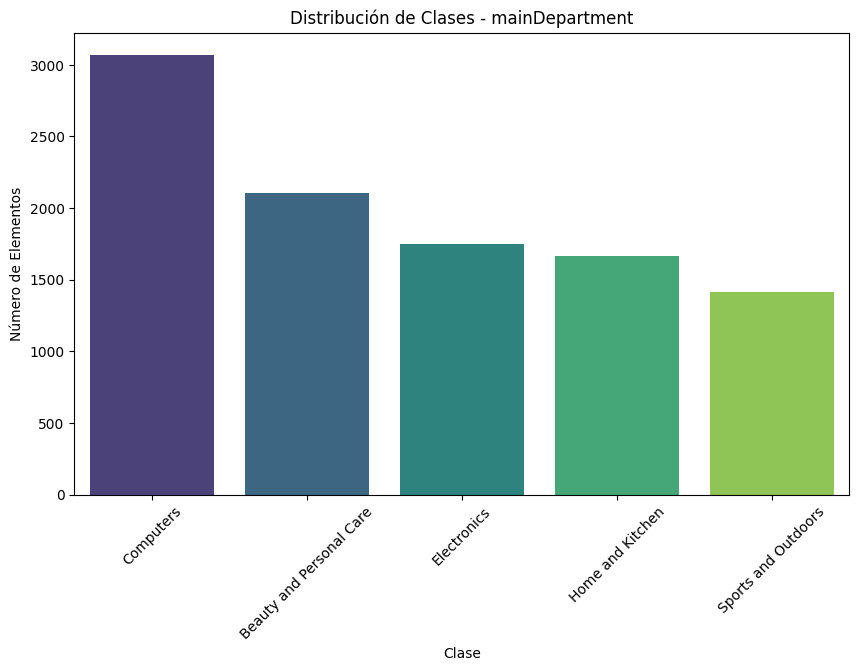

Limpiando el texto...
Texto limpiado y listo.
Generando nubes de palabras...


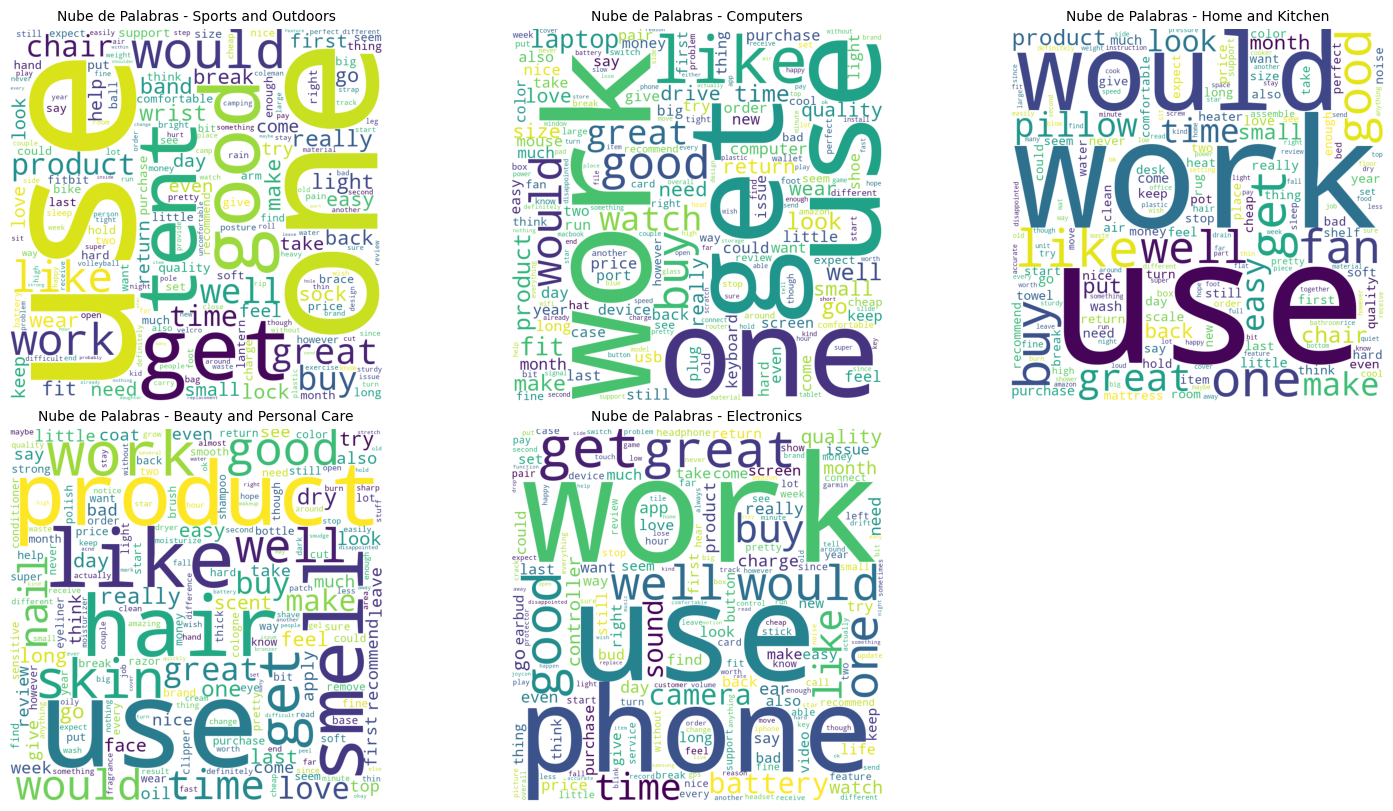

mainDepartment  \
0       Sports and Outdoors   
1                 Computers   
2                 Computers   
3          Home and Kitchen   
4  Beauty and Personal Care   

                                          reviewText  \
0  Nice lightweight brace but unfortunately was t...   
1  Boxers were ok. The color did start to fade pr...   
2  Very easy to install. Worked right away but it...   
3  The color is completely different than hunter ...   
4  From reading the reviews, I was hoping that th...   

                                        cleaned_text  
0  nice lightweight brace unfortunately large wri...  
1  boxer ok color start fade pretty quickly becom...  
2  easy install work right away go far expectedit...  
3  color completely different hunter green andor ...  
4  read review hope shampoo conditioner would ext...

In [6]:
# Instanciar la clase con las columnas relevantes
exploracion = sn.ExploracionText(dataframe=df, text_column='reviewText', label_column='mainDepartment', language="english")

# Explorar los datos
exploracion.explorar_datos()

# Limpiar los textos
exploracion.limpiar_textos("cleaned_text")

# Generar nubes de palabras
exploracion.generar_wordclouds()

# Obtener el DataFrame limpio
df_limpio = exploracion.obtener_dataframe_limpio()

# Ver las primeras filas del DataFrame limpio
df_limpio.head()


In [7]:
# instanciamos la clase
representador = sn.RepresentacionTexto(dataframe=df_limpio, text_column='cleaned_text')

# representamos el texto usando  Bag of Words
bow_df = representador.generar_bow()
print("Bag of Words:")
display(bow_df.sample(10))

# representamos el texto usando TF-IDF
tfidf_df = representador.generar_tfidf()
print("TF-IDF:")
display(tfidf_df.sample(10))

# representammos el texto usando  Embeddings
embeddings_df = representador.generar_embeddings()
print("Embeddings:")
display(embeddings_df.sample(10))


Generando Bag of Words...
Bag of Words generado.
Bag of Words:


mainDepartment  \
7709       Sports and Outdoors   
726   Beauty and Personal Care   
3774               Electronics   
3227       Sports and Outdoors   
9560       Sports and Outdoors   
1231          Home and Kitchen   
5098  Beauty and Personal Care   
143                Electronics   
6085                 Computers   
9475                 Computers   

                                             reviewText  \
7709  The product fits when worn correctly and for t...   
726   It goes on easily but does not stay on all day...   
3774  what is there to say.. it works and does the j...   
3227  I played with it and it’s light and i’m a begi...   
9560  Ordered socks for my usual shoe size, and they...   
1231  They shed and aren't very absorbent at first; ...   
5098  Not a big fan of this. The base coat never dri...   
143   Cameras are I reliable. They turn off intermit...   
6085  Elastic is Flimsy. Ripped off after only a few...   
9475  Faulty product. Failed after approx. one year....   

                                           cleaned_text  aa  ability  able  \
7709  product fit wear correctly price reasonable en...   0        0     0   
726   go easily stay day time get home melt eyelid u...   0        0     0   
3774                 say work job capture k video drone   0        0     0   
3227  play light beginner ball make hand red soft ba...   0        0     0   
9560  order sock usual shoe size small cause run unc...   0        0     0   
1231  would absorbent first several washing vinegar ...   0        0     0   
5098  big fan base coat never dry know kind okay bas...   0        0     0   
143   camera reliable turn intermittently need secur...   0        0     0   
6085                            elastic flimsy rip wear   0        0     0   
9475  faulty product fail approx one year corrupt da...   0        0     0   

      abrasive  abs  absolute  absolutely  absorb  absorbency  absorbent  \
7709         0    0         0           0       0           0          0   
726          0    0         0           0       0           0          0   
3774         0    0         0           0       0           0          0   
3227         0    0         0           0       0           0          0   
9560         0    0         0           0       0           0          0   
1231         0    0         0           0       0           0          2   
5098         0    0         0           0       0           0          0   
143          0    0         0           0       0           0          0   
6085         0    0         0           0       0           0          0   
9475         0    0         0           0       0           0          0   

      absurd  abuse  ac  accent  accentuate  accept  acceptable  access  \
7709       0      0   0       0           0       0           0       0   
726        0      0   0       0           0       0           0       0   
3774       0      0   0       0           0       0           0       0   
3227       0      0   0       0           0       0           0       0   
9560       0      0   0       0           0       0           0       0   
1231       0      0   0       0           0       0           0       0   
5098       0      0   0       0           0       0           0       0   
143        0      0   0       0           0       0           0       0   
6085       0      0   0       0           0       0           0       0   
9475       0      0   0       0           0       0           0       0   

      accessible  accessory  accident  accidental  accidentally  accidently  \
7709           0          0         0           0             0           0   
726            0          0         0           0             0           0   
3774           0          0         0           0             0           0   
3227           0          0         0           0             0           0   
9560           0          0         0           0             0           

Generando representación TF-IDF...
Representación TF-IDF generada.
TF-IDF:


mainDepartment  \
6308  Beauty and Personal Care   
8826          Home and Kitchen   
568                Electronics   
7053  Beauty and Personal Care   
22                   Computers   
5591                 Computers   
7969       Sports and Outdoors   
4680  Beauty and Personal Care   
7397                 Computers   
9202               Electronics   

                                             reviewText  \
6308                         Works great, smells awful.   
8826  It’s small and easy to move and fits in little...   
568   Tried several times during my workout ro get t...   
7053  It makes my cuticles very thick and hard to cu...   
22    This was a waste of money for me. I travel in ...   
5591  When I first using this product, I thought my ...   
7969  Chair worked well at first but after about a m...   
4680  The product docent show any improvement made o...   
7397  Storage capacity is 32gb which is okay. Though...   
9202  Put in our security camera & now we are able t...   

                                           cleaned_text   aa  ability  \
6308                             work great smell awful  0.0      0.0   
8826  small easy move fit little place give lot heat...  0.0      0.0   
568   try several time workout ro get heart rate sen...  0.0      0.0   
7053  make cuticle thick hard cut really sure help n...  0.0      0.0   
22    waste money travel van full time limit usb por...  0.0      0.0   
5591  first use product think phone problem product ...  0.0      0.0   
7969  chair work well first month fair usei lb man m...  0.0      0.0   
4680  product docent show improvement make face smel...  0.0      0.0   
7397  storage capacity gb okay though carrying bag s...  0.0      0.0   
9202  put security camera able use camera intend use...  0.0      0.0   

          able  abrasive  abs  absolute  absolutely  absorb  absorbency  \
6308  0.000000       0.0  0.0       0.0         0.0     0.0         0.0   
8826  0.000000       0.0  0.0       0.0         0.0     0.0         0.0   
568   0.000000       0.0  0.0       0.0         0.0     0.0         0.0   
7053  0.000000       0.0  0.0       0.0         0.0     0.0         0.0   
22    0.155590       0.0  0.0       0.0         0.0     0.0         0.0   
5591  0.000000       0.0  0.0       0.0         0.0     0.0         0.0   
7969  0.000000       0.0  0.0       0.0         0.0     0.0         0.0   
4680  0.000000       0.0  0.0       0.0         0.0     0.0         0.0   
7397  0.000000       0.0  0.0       0.0         0.0     0.0         0.0   
9202  0.293523       0.0  0.0       0.0         0.0     0.0         0.0   

      absorbent  absurd  abuse   ac  accent  accentuate  accept  acceptable  \
6308        0.0     0.0    0.0  0.0     0.0         0.0     0.0         0.0   
8826        0.0     0.0    0.0  0.0     0.0         0.0     0.0         0.0   
568         0.0     0.0    0.0  0.0     0.0         0.0     0.0         0.0   
7053        0.0     0.0    0.0  0.0     0.0         0.0     0.0         0.0   
22          0.0     0.0    0.0  0.0     0.0         0.0     0.0         0.0   
5591        0.0     0.0    0.0  0.0     0.0         0.0     0.0         0.0   
7969        0.0     0.0    0.0  0.0     0.0         0.0     0.0         0.0   
4680        0.0     0.0    0.0  0.0     0.0         0.0     0.0         0.0   
7397        0.0     0.0    0.0  0.0     0.0         0.0     0.0         0.0   
9202        0.0     0.0    0.0  0.0     0.0         0.0     0.0         0.0   

      access  accessible  accessory  accident  accidental  accidentally  \
6308     0.0         0.0        0.0       0.0         0.0           0.0   
8826     0.0         0.0        0.0       0.0         0.0           0.0   
568      0.0         0.0        0.0       0.0         0.0           0.0   
7053     0.0         0.0        0.0       0.0         0.0           0.0   
22       0.0         0.0        0.0       0.0         0.0           0.0   
5591     0.0         0.0        0.0      

Generando embeddings...
Embeddings generados.
Embeddings:


mainDepartment  \
7949                 Computers   
2781  Beauty and Personal Care   
2950                 Computers   
3718          Home and Kitchen   
9811       Sports and Outdoors   
9858  Beauty and Personal Care   
6671  Beauty and Personal Care   
6731  Beauty and Personal Care   
5347                 Computers   
991                  Computers   

                                             reviewText  \
7949                             Happy with my purchase   
2781  Non greasy and absorbs well.  Perfect daytime ...   
2950  I bought them for my husband,  he’s a size 10 ...   
3718  It was way to stuffed and puffy of a pillow an...   
9811  Work well for pasture but painful after a long...   
9858   Didn’t do anything at all. Spent $17 on nothing.   
6671  This stuff stinks and directions didn't make a...   
6731                             Painful to use on skin   
5347  Has no support. I used to sell new balance and...   
991   Easy to set up, liked the keyboard. I added an...   

                                           cleaned_text  embedding_0  \
7949                                     happy purchase     0.028209   
2781  non greasy absorb well perfect daytime moistur...     0.094830   
2950  buy husband size laugh finger would go inside ...    -0.031343   
3718  way stuff puffy pillow make uncomortable hurt ...    -0.344823   
9811  work well pasture painful long use uncomfortab...    -0.127973   
9858                             anything spend nothing     0.271748   
6671  stuff stink direction make anything stinky liq...     0.244349   
6731                                   painful use skin     0.139149   
5347  support use sell new balance must own differen...     0.320513   
991   easy set like keyboard add another gb memory n...    -0.255085   

      embedding_1  embedding_2  embedding_3  embedding_4  embedding_5  \
7949    -0.207054    -0.023127     0.207070     0.224407    -0.089003   
2781    -0.154753     0.573073     0.148068     0.307407    -0.248886   
2950    -0.289764     0.466478     0.361024     0.303871    -0.067422   
3718     0.010894     0.426559    -0.147926     0.292772    -0.386151   
9811     0.136669    -0.115825    -0.269298     0.093529    -0.025944   
9858    -0.002319     0.081623     0.061617     0.118340    -0.503733   
6671     0.348038     0.442055    -0.171906     0.202146    -0.499309   
6731     0.176667    -0.491930    -0.005614    -0.063961     0.140904   
5347    -0.078311     0.548058    -0.105842     0.323117    -0.167826   
991     -0.275568     0.561061     0.296187     0.321071    -0.224155   

      embedding_6  embedding_7  embedding_8  embedding_9  embedding_10  \
7949     0.111625     0.185077    -0.025500    -0.245262      0.011852   
2781     0.155181     0.223356     0.276221    -0.359750      0.227443   
2950     0.013446    -0.096044     0.010328    -0.119802      0.249536   
3718     0.218680     0.469907     0.133684    -0.437605      0.056034   
9811     0.283514     0.143624     0.222520    -0.243991      0.128460   
9858     0.275675     0.217917     0.182833    -0.504391      0.025451   
6671     0.395846     0.367492     0.125814    -0.178926     -0.004498   
6731     0.382657     0.043016     0.113292    -0.615914     -0.037296   
5347     0.281782     0.164625     0.327557    -0.433647      0.346649   
991     -0.036480     0.225289     0.071431    -0.296697      0.219863   

      embedding_11  embedding_12  embedding_13  embedding_14  embedding_15  \
7949      0.081671     -0.028816     -0.009379     -0.327763     -0.221818   
2781      0.122815      0.423210      0.168479     -0.502069      0.359791   
2950     -0.090701      0.214408      0.415179     -0.588893      0.027408   
3718     -0.403282      0.146732      0.275967     -1.174174      0.262093   
9811      0.361797      0.147196      0.176390     -0.410340      0.646726   
9858      0.143448      0.286812      0.409862     -0.528190     -0.346405   
6671     -0.374708     -0.051374 

In [10]:
embeddings_df.shape

(10000, 771)

Aplicando PCA para reducir 768 dimensiones a 50 dimensiones...
Reducción completada. Nuevas dimensiones agregadas al DataFrame.


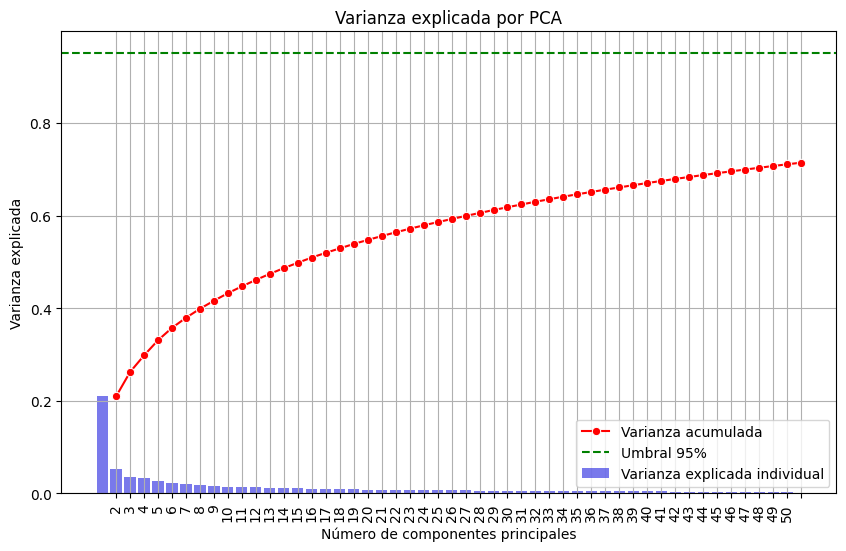

mainDepartment  \
0       Sports and Outdoors   
1                 Computers   
2                 Computers   
3          Home and Kitchen   
4  Beauty and Personal Care   

                                          reviewText  \
0  Nice lightweight brace but unfortunately was t...   
1  Boxers were ok. The color did start to fade pr...   
2  Very easy to install. Worked right away but it...   
3  The color is completely different than hunter ...   
4  From reading the reviews, I was hoping that th...   

                                        cleaned_text  pca_componente_0  \
0  nice lightweight brace unfortunately large wri...          1.738611   
1  boxer ok color start fade pretty quickly becom...          1.355272   
2  easy install work right away go far expectedit...          1.172380   
3  color completely different hunter green andor ...         -0.614810   
4  read review hope shampoo conditioner would ext...          1.649754   

   pca_componente_1  pca_componente_2  pca_componente_3  pca_componente_4  \
0          0.152096          0.534141          1.832110         -0.816322   
1          0.458492         -0.802558         -0.301389         -0.158522   
2          0.192169          1.661863         -0.464872          0.199373   
3          1.366463          0.033115         -0.170324          0.379125   
4          1.405461         -0.461965          1.296250          1.136927   

   pca_componente_5  pca_componente_6  pca_componente_7  pca_componente_8  \
0         -1.244745          1.722020          1.459970          1.009784   
1          0.141087          0.751444         -0.718584          0.725925   
2         -0.554890          0.587701         -0.314332         -0.909666   
3         -0.534526         -1.089790          0.745800         -0.056248   
4          0.547935         -1.269538          0.139595          0.209027   

   pca_componente_9  pca_componente_10  pca_componente_11  pca_componente_12  \
0          0.882299           0.135578          -0.165954          -0.182332   
1         -0.804344           0.458621          -0.497514          -0.060458   
2          0.361948           1.770641          -0.471117           0.258072   
3         -1.611180           0.816055           0.083503           0.162007   
4         -0.236300           0.056385           0.057113           0.357153   

   pca_componente_13  pca_componente_14  pca_componente_15  pca_componente_16  \
0           0.251779           0.725212           0.229637           0.080232   
1           0.871171           0.451823           0.104462          -0.301944   
2           0.017059           0.128617           0.044808           0.786050   
3          -0.255736          -0.253314          -0.664981          -0.305911   
4          -0.172052           0.205548           0.094611           0.547622   

   pca_componente_17  pca_componente_18  pca_componente_19  pca_componente_20  \
0          -0.739866           0.111892           0.207432          -0.426197   
1           0.662372           0.455220          -0.655192          -0.152929   
2           0.389980           0.415541          -0.342177           0.388551   
3           1.304921          -0.739850           0.183743           0.350289   
4           0.340682          -0.071392           0.332725           0.382343   

   pca_componente_21  pca_componente_22  pca_componente_23  pca_componente_24  \
0          -0.433528          -0.001693          -0.401691           0.390502   
1          -0.259620           0.043931           0.539019          -0.709168   
2           0.054832           0.559117           0.136166           0.064887   
3          -0.286538          -1.027641          -0.482453          -1.005213   
4          -0.138290           0.173985          -0.243955          -0.063370   

   pca_componente_25  pca_componente_26  pca_componente_27  pca_componente_28  \
0          -0.242509           0.053073          -0.074080          -0.351965   
1           0.

In [12]:
# Instanciar la clase para reducción de dimensionalidad
reductor_pca = sn.ReduccionDimensionalidadPCA(n_componentes=50)

# Lista de columnas de embeddings a reducir
columnas_embeddings = [f"embedding_{i}" for i in range(768)]

# Aplicar reducción de dimensionalidad
df_reducido_emb = reductor_pca.ajustar_transformar(embeddings_df, columnas_embeddings)

# Mostrar la varianza explicada por los componentes principales
varianza_acumulada = reductor_pca.explicar_varianza(mostrar_grafico=True)

# El DataFrame 'df_reducido' contiene las nuevas columnas reducidas como 'pca_componente_0', ..., 'pca_componente_49'
df_reducido_emb.head()

In [13]:
# Rellenar valores nulos y forzar a tipo texto
df['reviewText'] = df['reviewText'].fillna("").astype(str)

Aplicando PCA para reducir 5000 dimensiones a 50 dimensiones...
Reducción completada. Nuevas dimensiones agregadas al DataFrame.


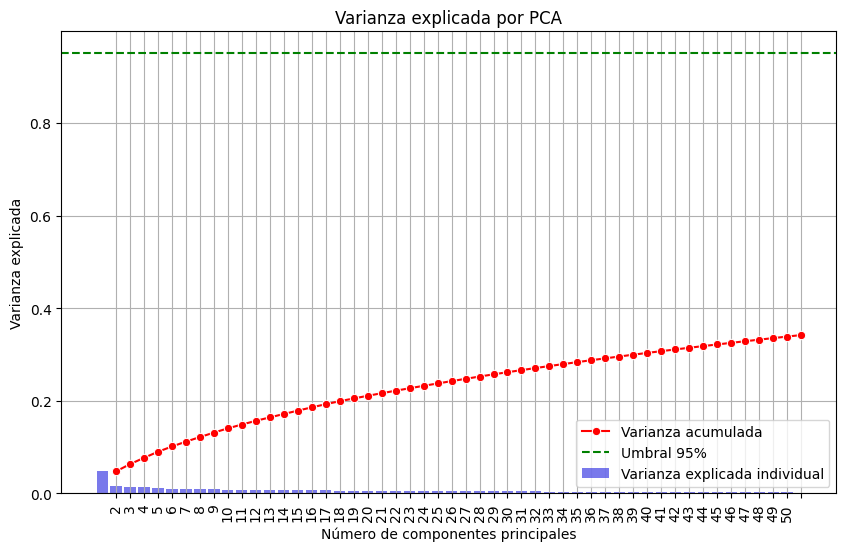

mainDepartment  \
0       Sports and Outdoors   
1                 Computers   
2                 Computers   
3          Home and Kitchen   
4  Beauty and Personal Care   

                                          reviewText  \
0  Nice lightweight brace but unfortunately was t...   
1  Boxers were ok. The color did start to fade pr...   
2  Very easy to install. Worked right away but it...   
3  The color is completely different than hunter ...   
4  From reading the reviews, I was hoping that th...   

                                        cleaned_text  pca_componente_0  \
0  nice lightweight brace unfortunately large wri...         -0.565127   
1  boxer ok color start fade pretty quickly becom...         -0.616673   
2  easy install work right away go far expectedit...         -0.155211   
3  color completely different hunter green andor ...         -0.670184   
4  read review hope shampoo conditioner would ext...          0.031709   

   pca_componente_1  pca_componente_2  pca_componente_3  pca_componente_4  \
0         -0.126630         -0.176568          0.016749         -0.053887   
1         -0.027764         -0.181382          0.117720         -0.052353   
2         -0.334498          0.443115          0.339245          0.011913   
3         -0.021853         -0.097107          0.015825         -0.074657   
4         -0.266228          0.678101          0.060007          0.864083   

   pca_componente_5  pca_componente_6  pca_componente_7  pca_componente_8  \
0         -0.017763         -0.142822         -0.104602          0.127824   
1         -0.016711         -0.078212         -0.029608         -0.020385   
2         -0.307143         -0.297059          0.355227         -0.543074   
3         -0.010735          0.004156         -0.122981          0.118812   
4         -0.050456         -0.078209          0.101083          0.474900   

   pca_componente_9  pca_componente_10  pca_componente_11  pca_componente_12  \
0         -0.095751           0.009234           0.231084          -0.050608   
1          0.098435          -0.004942           0.028448           0.002938   
2          0.164563          -0.478291          -0.034842          -0.072644   
3          0.064898           0.039215           0.093476          -0.025730   
4         -0.260027          -0.761841          -0.641617          -0.195992   

   pca_componente_13  pca_componente_14  pca_componente_15  pca_componente_16  \
0           0.058133          -0.387524          -0.132873          -0.183070   
1           0.155675           0.008527          -0.116634          -0.159613   
2          -0.347395           0.209886          -0.100292          -0.115602   
3          -0.020977          -0.108173          -0.011671          -0.041589   
4           0.294246          -0.592065           0.720501          -0.024842   

   pca_componente_17  pca_componente_18  pca_componente_19  pca_componente_20  \
0           0.486105           0.133121          -0.087581           0.469769   
1          -0.040967          -0.140325           0.121918           0.061829   
2           0.196625          -0.195424          -0.223294          -0.121089   
3          -0.059473          -0.050783           0.083807          -0.118501   
4          -0.130231           0.118101          -0.070296          -0.095130   

   pca_componente_21  pca_componente_22  pca_componente_23  pca_componente_24  \
0           0.304413           0.016813           0.244842           0.127959   
1           0.076972          -0.040397           0.075493          -0.096762   
2          -0.268429          -0.096757          -0.167043          -0.043690   
3          -0.061776          -0.130602           0.110796           0.078517   
4           0.037450          -0.018327          -0.170778          -0.292306   

   pca_componente_25  pca_componente_26  pca_componente_27  pca_componente_28  \
0          -0.367632          -0.161653           0.345146           0.327420   
1           0.

In [16]:
# Seleccionar columnas numéricas para reducir
columnas_a_reducir_bow = bow_df.columns.difference(['reviewText', 'mainDepartment', 'cleaned_text'])


# Aplicar reducción de dimensionalidad
df_reducido_bow = reductor_pca.ajustar_transformar(bow_df, columnas_a_reducir_bow)

# Mostrar la varianza explicada por los componentes principales
varianza_acumulada_bow = reductor_pca.explicar_varianza(mostrar_grafico=True)

# El DataFrame 'df_reducido' contiene las nuevas columnas reducidas como 'pca_componente_0', ..., 'pca_componente_49'
df_reducido_bow.head()

Aplicando PCA para reducir 5000 dimensiones a 50 dimensiones...
Reducción completada. Nuevas dimensiones agregadas al DataFrame.


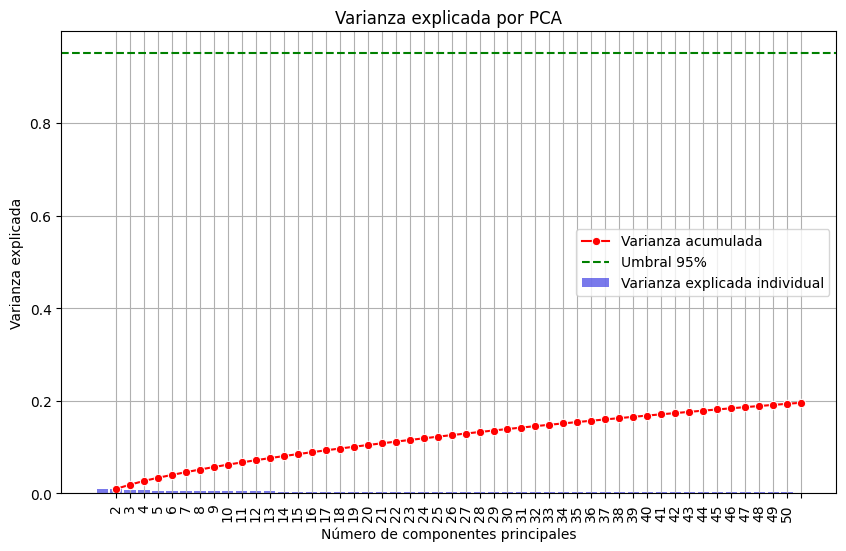

mainDepartment  \
0       Sports and Outdoors   
1                 Computers   
2                 Computers   
3          Home and Kitchen   
4  Beauty and Personal Care   

                                          reviewText  \
0  Nice lightweight brace but unfortunately was t...   
1  Boxers were ok. The color did start to fade pr...   
2  Very easy to install. Worked right away but it...   
3  The color is completely different than hunter ...   
4  From reading the reviews, I was hoping that th...   

                                        cleaned_text  pca_componente_0  \
0  nice lightweight brace unfortunately large wri...         -0.072778   
1  boxer ok color start fade pretty quickly becom...         -0.047274   
2  easy install work right away go far expectedit...          0.098812   
3  color completely different hunter green andor ...         -0.039113   
4  read review hope shampoo conditioner would ext...          0.067082   

   pca_componente_1  pca_componente_2  pca_componente_3  pca_componente_4  \
0         -0.048526         -0.003413         -0.117277          0.064494   
1          0.004795          0.015614         -0.048564          0.014778   
2          0.182996         -0.097038          0.003181         -0.066598   
3         -0.037840          0.002508         -0.032802          0.026568   
4         -0.029712         -0.061514          0.051492          0.033707   

   pca_componente_5  pca_componente_6  pca_componente_7  pca_componente_8  \
0         -0.032259          0.089001          0.122657          0.106349   
1          0.008491         -0.017152         -0.018525          0.041546   
2          0.104068         -0.070093          0.117245          0.031434   
3          0.022194         -0.011200         -0.013236          0.030464   
4         -0.031814          0.012419          0.039436         -0.032864   

   pca_componente_9  pca_componente_10  pca_componente_11  pca_componente_12  \
0         -0.046178          -0.087893           0.092315           0.043542   
1          0.045894          -0.014563          -0.059538          -0.019766   
2         -0.002483          -0.002082          -0.112786          -0.023983   
3          0.022311          -0.019475          -0.040043          -0.002306   
4          0.162485           0.060754           0.034140           0.162434   

   pca_componente_13  pca_componente_14  pca_componente_15  pca_componente_16  \
0           0.008526          -0.030121          -0.017533           0.019586   
1           0.055766           0.036907           0.006748          -0.010477   
2           0.002216          -0.084253          -0.005172          -0.007825   
3          -0.022362           0.025385           0.015022          -0.015381   
4          -0.004994           0.027151          -0.025320           0.020187   

   pca_componente_17  pca_componente_18  pca_componente_19  pca_componente_20  \
0           0.006388          -0.009700           0.014874          -0.002541   
1          -0.035773          -0.007860          -0.005278          -0.073317   
2          -0.171654           0.013404           0.176963           0.022403   
3           0.021702          -0.012694          -0.021993          -0.018052   
4          -0.012874           0.082150          -0.003997          -0.014112   

   pca_componente_21  pca_componente_22  pca_componente_23  pca_componente_24  \
0          -0.053285           0.002567          -0.016946          -0.012219   
1           0.014954           0.255932           0.077495           0.107033   
2           0.101131          -0.033980          -0.054543          -0.120431   
3           0.032935          -0.007471           0.010083          -0.042755   
4          -0.014474          -0.003508           0.017486           0.006132   

   pca_componente_25  pca_componente_26  pca_componente_27  pca_componente_28  \
0           0.011740           0.026451           0.011941          -0.007175   
1          -0.

In [17]:
# Seleccionar columnas numéricas para reducir
columnas_a_reducir_tf = bow_df.columns.difference(['reviewText', 'mainDepartment', 'cleaned_text'])


# Aplicar reducción de dimensionalidad
df_reducido_tf = reductor_pca.ajustar_transformar(tfidf_df, columnas_a_reducir_tf)

# Mostrar la varianza explicada por los componentes principales
varianza_acumulada_tf = reductor_pca.explicar_varianza(mostrar_grafico=True)

# El DataFrame 'df_reducido' contiene las nuevas columnas reducidas como 'pca_componente_0', ..., 'pca_componente_49'
df_reducido_tf.head()